<a href="https://colab.research.google.com/github/romanAVJ/Ido_proyectos/blob/master/nn_main_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get .py files and data from GitHub Repo

First clone the entire repository to local file and then start 

In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/romanAVJ/Optimal_Bets_PremierLeague.git cloned-repo

# move to folder "cloned repo"
%cd cloned-repo


Cloning into 'cloned-repo'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 98 (delta 19), reused 94 (delta 17), pack-reused 0
Unpacking objects: 100% (98/98), done.
/content/cloned-repo


In [ ]:
# look that we are in the right place
! ls 

Data  nn_models.ipynb  README.md  Results  Source


## Import libraries and .py files

In [ ]:
# manually install dependencies of files
# adjustText
!pip install adjustText 
!pip install keras-tuner --upgrade

# uninstall scikit-learn (old verison) and install new version (>= 0.24)
!pip uninstall scikit-learn -y
!pip install -U scikit-learn
!pip uninstall sklearn -y
!pip install -U sklearn

# get libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt

from tensorflow import keras
import os 
import random

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from adjustText import adjust_text

import Source.statistical_learning_model.nn_utils as nn_utils_ravj
from sklearn.model_selection import TimeSeriesSplit


  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=623b2a77299c242646ddfbcda66da80c06bcb594480396155aaeddceae5aa76c
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText
     |████████████████████████████████| 97 kB 3.8 MB/s 
Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 23.1 MB 1.5 MB/s 
Found existing installation: sklearn 0.0
Uninstalling sklearn-0.0:
  Successfully uninstalled sklearn-0.0
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=eea43463dbd75a34befcd1bd673c2bd2278f4f1614916a91329681220af65c7d
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


# Functions


## Tidy dataframes and get data

In [ ]:
## data functions
def get_dummies_results(df, var='y', prefix='y'):
    # working data frame
    df_work = df.copy()
    
    # one hot encode results
    y = pd.get_dummies(df_work[var], prefix=prefix, drop_first=False, dtype=int)
    names_y = y.columns.values
    
    # append to dataframe
    df_work[names_y] = y
    
    # reorder columns
    columns_names = df_work.columns.values
    columns_names = np.concatenate([names_y, columns_names[:-3]]) # number of y dummies'
    df_work = df_work[columns_names]
    
    # drop result
    df_work.drop(columns=var, inplace=True)
    
    return(df_work, list(names_y))

def split_trainvaltest(df, queries, objective_var='y', var='x'):    
    # working dataframe
    df_work = df.copy()    
    
    # get train, validation and test
    dbb = {}    
    for k,v in queries.items():
        df_subset = df_work.query(v)
        
        # save objective and covariables in dataframe
        dbb[k] = {'y': df_subset[objective_var], 'X': df_subset[var]}
        
    return(dbb)

def tidy_bdd(df, queries, objective_var='y', var='x'): 
    # working data frame
    df_work = df.copy()
    
    # get dummies
    df_work, names_y = get_dummies_results(df_work, var=objective_var, prefix=objective_var)
    
    # mutate matchweek to normalize it (lost generalization in functions)
    df_work['matchweek'] = df_work.groupby('season')['matchweek'].\
        transform(lambda x: (x - min(x))/(max(x) - min(x)))   
    
    # get train, validation and test
    dbb = split_trainvaltest(df_work, queries, objective_var=names_y, var=var)  
    
    return(dbb)


## Generate models for hyperparams

In [ ]:
# model 1:  Elastic Net
def build_model_elastic(hp):
  # init randomness
  nn_utils_ravj._reset_random_seeds(8)
  n_covars = 21
  n_l = 4

  #### hyper params ####
  # lambda penalization
  dic_lambdas = {
      'layer' + str(i+1): hp.Float(
        name='elastic_lambda_l' + str(i+1),
        min_value=1e-4,
        max_value=1e-2
      ) 
      for i in range(n_l)
  }

  # alpha (convex combination between lasso & ridge)
  dic_alphas = {
      'layer' + str(i+1): hp.Float(
        name='elastic_alpha_l' + str(i+1),
        min_value=0,
        max_value=1,
        default=0.5
      ) for i in range(n_l)
  }

  # number of neurons
  # create a funnel architecture
  dic_units = dict()
  for i in range(n_l - 1):
    if i == 0:
      dic_units['layer1'] = hp.Int(
        name='units_l1',
        min_value=n_covars,
        max_value=n_covars*2,
        step=4,
        default=n_covars # initial value
      )
    else:
      dic_units['layer' + str(i+1)] = hp.Int(
        name='units_l' + str(i+1),
        min_value=dic_units['layer' + str(i)],
        max_value=dic_units['layer' + str(i)]*2,
        step=4,
        default=dic_units['layer' + str(i)] # initial value
      )

  # learning rate
  lr_r = hp.Choice(
      name = "lr", 
      values = [1e-2, 1e-3, 1e-4]
    )

  #### create model ####
  model = keras.Sequential()
  # layers
  for i in range(n_l - 1):
    ikey = str(i+1)
    model.add(
        keras.layers.Dense(
            units=dic_units['layer' + ikey],
            activation='relu',
            kernel_initializer='he_normal',
            kernel_regularizer=keras.regularizers.l1_l2(
                l1=dic_lambdas['layer' + ikey] * dic_alphas['layer' + ikey],     # Hastie & Tibshiranie formulation of elastic net 
                l2=dic_lambdas['layer' + ikey] * (1 - dic_alphas['layer' + ikey]) / 2  # Hastie & Tibshiranie formulation of elastic net 
              ),
            dtype=np.float64
        )
    )

  # final layer
  model.add(
      keras.layers.Dense(
        units=3, # three final classes
        activation='softmax',
        kernel_initializer=keras.initializers.GlorotNormal(),
        kernel_regularizer=keras.regularizers.l1_l2(
            l1=dic_lambdas['layer' + str(n_l)] * dic_alphas['layer' + str(n_l)],
            l2=dic_lambdas['layer' + str(n_l)] * (1 - dic_alphas['layer' + str(n_l)]) / 2  
          ),
        dtype=np.float64          
      )
  )

  # compile model
  model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

  return(model)


# model 2:  Lasso
def build_model_lasso(hp):
  # init randomness
  nn_utils_ravj._reset_random_seeds(8)
  n_covars = 21
  n_l = 4

  #### hyper params ####
  # lambda penalization
  dic_lambdas = {
      'layer' + str(i+1): hp.Float(
        name='elastic_lambda_l' + str(i+1),
        min_value=1e-4,
        max_value=1e-2
      ) 
      for i in range(n_l)
  }

  # number of layers
  # create a funnel architecture
  dic_units = dict()
  for i in range(n_l - 1):
    if i == 0:
      dic_units['layer1'] = hp.Int(
        name='units_l1',
        min_value=n_covars,
        max_value=n_covars*2,
        step=4,
        default=n_covars # initial value
      )
    else:
      dic_units['layer' + str(i+1)] = hp.Int(
        name='units_l' + str(i+1),
        min_value=dic_units['layer' + str(i)],
        max_value=dic_units['layer' + str(i)]*2,
        step=4,
        default=dic_units['layer' + str(i)] # initial value
      )

  # learning rate
  lr_r = hp.Choice(
      name = "lr", 
      values = [1e-2, 1e-3, 1e-4]
    )

  #### create model ####
  model = keras.Sequential()
  # layers
  for i in range(n_l - 1):
    ikey = str(i+1)
    model.add(
        keras.layers.Dense(
            units=dic_units['layer' + ikey],
            activation='relu',
            kernel_initializer='he_normal',
            kernel_regularizer=keras.regularizers.l1(dic_lambdas['layer' + ikey]),
            dtype=np.float64
        )
    )

  # final layer
  model.add(
      keras.layers.Dense(
        units=3, # three final classes
        activation='softmax',
        kernel_initializer=keras.initializers.GlorotNormal(),
        kernel_regularizer=keras.regularizers.l1(dic_lambdas['layer' + ikey]),
        dtype=np.float64          
      )
  )

  # compile model
  model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

  return(model)


# model 3:  Ridge
def build_model_ridge(hp):
  # init randomness
  nn_utils_ravj._reset_random_seeds(8)
  n_covars = 21
  n_l = 4


  #### hyper params ####
  # lambda penalization
  dic_lambdas = {
      'layer' + str(i+1): hp.Float(
        name='elastic_lambda_l' + str(i+1),
        min_value=1e-4,
        max_value=1e-2
      ) 
      for i in range(n_l)
  }

  # number of neurons
  # create a funnel architecture
  dic_units = dict()
  for i in range(n_l - 1):
    if i == 0:
      dic_units['layer1'] = hp.Int(
        name='units_l1',
        min_value=n_covars,
        max_value=n_covars*2,
        step=4,
        default=n_covars # initial value
      )
    else:
      dic_units['layer' + str(i+1)] = hp.Int(
        name='units_l' + str(i+1),
        min_value=dic_units['layer' + str(i)],
        max_value=dic_units['layer' + str(i)]*2,
        step=4,
        default=dic_units['layer' + str(i)] # initial value
      )

  # learning rate
  lr_r = hp.Choice(
      name = "lr", 
      values = [1e-2, 1e-3, 1e-4]
    )

  #### create model ####
  model = keras.Sequential()
  # layers
  for i in range(n_l - 1):
    ikey = str(i+1)
    model.add(
        keras.layers.Dense(
            units=dic_units['layer' + ikey],
            activation='relu',
            kernel_initializer='he_normal',
            kernel_regularizer=keras.regularizers.l2(dic_lambdas['layer' + ikey]),
            dtype=np.float64
        )
    )

  # final layer
  model.add(
      keras.layers.Dense(
        units=3, # three final classes
        activation='softmax',
        kernel_initializer=keras.initializers.GlorotNormal(),
        kernel_regularizer=keras.regularizers.l2(dic_lambdas['layer' + ikey]),
        dtype=np.float64          
      )
  )

  # compile model
  model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

  return(model)


# model 4:  DropOut
def build_model_dropout(hp):
  # init randomness
  nn_utils_ravj._reset_random_seeds(8)
  n_covars = 21
  n_l = 4

  #### hyper params ####
  # dropout
  dic_dropout_rate = {
      'layer' + str(i+1): hp.Float(
        name='rate_l' + str(i+1),
        min_value=1e-6,
        max_value=0.5,
        sampling='log'
        ) 
      for i in range(n_l - 1)
  }

  # number of layers
  # create a funnel architecture
  dic_units = dict()
  for i in range(n_l - 1):
    if i == 0:
      dic_units['layer1'] = hp.Int(
        name='units_l1',
        min_value=n_covars,
        max_value=n_covars*2,
        step=4,
        default=n_covars # initial value
      )
    else:
      dic_units['layer' + str(i+1)] = hp.Int(
        name='units_l' + str(i+1),
        min_value=dic_units['layer' + str(i)],
        max_value=dic_units['layer' + str(i)]*2,
        step=4,
        default=dic_units['layer' + str(i)] # initial value
      )

  # learning rate
  lr_r = hp.Choice(
      name = "lr", 
      values = [1e-2, 1e-3, 1e-4]
    )

  #### create model ####
  model = keras.Sequential()
  
  # layers
  for i in range(n_l - 1):
    ikey = str(i+1)
    # model layer
    model.add(
        keras.layers.Dense(
            units=dic_units['layer' + ikey],
            activation='relu',
            kernel_initializer='he_normal',
            dtype=np.float64
        )    
    )
    # model dropout
    model.add(
        keras.layers.Dropout(rate=dic_dropout_rate['layer' + ikey])        
    )


  # final layer
  model.add(
      keras.layers.Dense(
        units=3, # three final classes
        activation='softmax',
        kernel_initializer=keras.initializers.GlorotNormal(),
        dtype=np.float64          
      )
  )

  # compile model
  model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

  return(model)

# model 5:  Batch Normalization
def build_model_bn(hp):
    """
    Batch Normalization _before_ the activation function, as argued by
    F. Chollet and paper authors: S. Ioffe & C. Szegedy
    
    Parameters
    ----------
    hp : TYPE
        DESCRIPTION.
    
    Returns
    -------
    None.
    
    """
    # init randomness
    nn_utils_ravj._reset_random_seeds(8)
    n_covars = 21
    
    #### hyper params ####
    # number of layers
    n_l = hp.Int(
        name='n_l',
        min_value=2, # not a shallow nn
        max_value=10,
        default=5      
        )
    
    # create a funnel architecture
    dic_units = dict()
    for i in range(n_l - 1):
      if i == 0:
        dic_units['layer1'] = hp.Int(
          name='units_l1',
          min_value=n_covars,
          max_value=n_covars*2,
          step=4,
          default=n_covars # initial value
        )
      else:
        dic_units['layer' + str(i+1)] = hp.Int(
          name='units_l' + str(i+1),
          min_value=dic_units['layer' + str(i)],
          max_value=dic_units['layer' + str(i)]*2,
          step=4,
          default=dic_units['layer' + str(i)] # initial value
        )
  
    # learning rate
    lr_r = hp.Choice(
        name = "lr", 
        values = [1e-2, 1e-3, 1e-4]
      )
  
    #### create model ####
    # init
    model = keras.Sequential()
    # batch normalization
    model.add(keras.layers.BatchNormalization())
    
    # layers
    for i in range(n_l - 1):
        ikey = str(i+1)
        
        # compute Z score
        model.add(
            keras.layers.Dense(
                units=dic_units['layer' + ikey],
                kernel_initializer='he_normal',
                use_bias=False, # there isn't need of a bais term because is centered
                dtype=np.float
            )            
        )
        
        # compute A score
        model.add(keras.layers.Activation('elu'))
        
        # batch normalization
        model.add(keras.layers.BatchNormalization())
  
    # final layer
    model.add(
        keras.layers.Dense(
          units=3, # three final classes
          activation='softmax',
          kernel_initializer=keras.initializers.GlorotNormal(),
          dtype=np.float64          
        )
    )
  
    # compile model
    model.compile(
          optimizer=keras.optimizers.Nadam(learning_rate=lr_r),
          loss='categorical_crossentropy',
          metrics=['accuracy']
      )
  
    return(model)


# Setup data


In [ ]:
# init parasm
SEED_VALUE = 8

# read data
df_r = pd.read_csv("Data/Main_DBB/model_myscale.csv")

# generate trains / validation / test database (three tables)
vars_model = [
    'matchweek', 'total_pts_home',
    'npxGD_ma_home', 'npxGD_var_home', 'big_six_home',
    'position_table_away', 'total_pts_away',
    'npxGD_ma_away', 'npxGD_var_away', 'big_six_away',
    'promoted_team_away', 'att_home', 'def_home', 
    'transfer_budget_home', 'ip_home', 
    'att_away', 'def_away',
    'transfer_budget_away', 'ip_away', 
    'proba_h', 'proba_a'
  ]

# queries to part in train/val/test
queries_model = {
    'train':  'season < 20',
    'validation': 'season >= 20 & matchweek < 0.45',    # matchweek 18 (standarized)
    'test': 'season >= 20 & matchweek >= 0.45'          # normalized(18; max=38, min=2) = (18-2)/(38-2) = 0.444...
    }

dbb = tidy_bdd(df_r, queries=queries_model, objective_var='result', var=vars_model)

# look data base
dbb.get('train').get('X').describe()

,matchweek,total_pts_home,npxGD_ma_home,npxGD_var_home,big_six_home,position_table_away,total_pts_away,npxGD_ma_away,npxGD_var_away,big_six_away,promoted_team_away,att_home,def_home,transfer_budget_home,ip_home,att_away,def_away,transfer_budget_away,ip_away,proba_h,proba_a
count,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000,2220.000000
mean,0.500000,-0.012502,-0.010084,1.257990,0.300000,0.507433,0.001995,0.015510,1.255919,0.300000,0.151351,0.020449,0.027483,0.114290,0.385135,0.022433,0.029752,0.115313,0.383902,0.445553,0.308803
std,0.296652,1.001463,0.627713,0.619004,0.458361,0.299962,0.999171,0.627774,0.607556,0.458361,0.358472,0.990964,0.958845,0.969831,0.292012,0.993263,0.965821,0.970322,0.292737,0.201966,0.182642
min,0.000000,-2.166821,-1.933021,0.000000,0.000000,0.000000,-2.095657,-1.758819,0.000000,0.000000,0.000000,-2.231579,-2.501700,-1.334137,0.000000,-2.423877,-2.535188,-1.334137,0.000000,0.037577,0.023453
25%,0.250000,-0.811611,-0.461575,0.859697,0.000000,0.263158,-0.764888,-0.433364,0.858786,0.000000,0.000000,-0.628628,-0.719808,-0.592900,0.157895,-0.620037,-0.727890,-0.592900,0.157895,0.299620,0.173726
50%,0.500000,-0.178063,-0.113924,1.132317,0.000000,0.526316,-0.178016,-0.097547,1.131736,0.000000,0.000000,-0.138438,-0.158291,-0.129627,0.315789,-0.153186,-0.157501,-0.128759,0.315789,0.430700,0.279276
75%,0.750000,0.663157,0.382797,1.528581,1.000000,0.780702,0.670109,0.392524,1.541207,1.000000,0.000000,0.795474,0.705114,0.861064,0.631579,0.796697,0.719727,0.861064,0.631579,0.582526,0.410259
max,1.000000,3.202368,2.376635,5.257844,1.000000,1.000000,3.202368,2.423021,5.431222,1.000000,1.000000,2.647924,2.523599,2.064231,1.000000,2.679719,2.523599,2.064231,1.000000,0.924572,0.890472


# Train Models

## Elastic Net

In [ ]:
# save each model of the random search
# generate figure folder
folder_results = "Results/Models_NN_Search"
if not os.path.exists(folder_results):
  os.makedirs(folder_results)



# Model 1: Funnel Architecture, Elastic Net #
tuner_en = kt.RandomSearch(
    hypermodel=build_model_elastic,
    objective='val_loss',
    max_trials=10,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='elastic_net'
)

# start search
tuner_en.search(
    dbb.get('train').get('X'),
    dbb.get('train').get('y'),
    epochs=20,
    validation_data=(
        dbb.get('validation').get('X'),
        dbb.get('validation').get('y'),
    )
)



Trial 10 Complete [00h 00m 05s]
val_loss: 1.0472559928894043

Best val_loss So Far: 1.0320403575897217
Total elapsed time: 00h 01m 06s
INFO:tensorflow:Oracle triggered exit


### Look bets models

In [ ]:
tuner_en.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/elastic_net
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
elastic_lambda_l1: 0.0027877620212734613
elastic_lambda_l2: 0.005108810096325453
elastic_lambda_l3: 0.0015327334710733178
elastic_lambda_l4: 0.005011946081024086
elastic_alpha_l1: 0.731531130400211
elastic_alpha_l2: 0.1995887063541001
elastic_alpha_l3: 0.7915259359614659
elastic_alpha_l4: 0.14595480067964695
units_l1: 29
units_l2: 21
units_l3: 25
lr: 0.01
Score: 1.0320403575897217


## Lasso Penalization

In [ ]:
# Model 2: Funnel Architecture, Lasso Penalization #
tuner_lasso = kt.RandomSearch(
    hypermodel=build_model_lasso,
    objective='val_loss',
    max_trials=5,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='lasso'
)

# start search 
tuner_lasso.search(
    dbb.get('train').get('X'),
    dbb.get('train').get('y'),
    epochs=20,
    validation_data=(
        dbb.get('validation').get('X'),
        dbb.get('validation').get('y'),
    )
)

Trial 5 Complete [00h 00m 05s]
val_loss: 1.145202875137329

Best val_loss So Far: 1.0723049640655518
Total elapsed time: 00h 00m 29s
INFO:tensorflow:Oracle triggered exit


### Look bets models

In [ ]:
tuner_lasso.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/lasso
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
elastic_lambda_l1: 0.002344388007872383
elastic_lambda_l2: 0.004683772842368713
elastic_lambda_l3: 0.005756885687430145
elastic_lambda_l4: 0.004578557579747205
units_l1: 29
units_l2: 25
units_l3: 25
lr: 0.01
Score: 1.0723049640655518


## Ridge Penalization

In [ ]:
# Model 3: Funnel Architecture, Ridge Penalization #
tuner_ridge = kt.RandomSearch(
    hypermodel=build_model_ridge,
    objective='val_loss',
    max_trials=5,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='ridge'
)

# start search 
tuner_ridge.search(
    dbb.get('train').get('X'),
    dbb.get('train').get('y'),
    epochs=20,
    validation_data=(
        dbb.get('validation').get('X'),
        dbb.get('validation').get('y'),
    )
)

Trial 5 Complete [00h 00m 06s]
val_loss: 1.090043306350708

Best val_loss So Far: 1.013405442237854
Total elapsed time: 00h 00m 28s
INFO:tensorflow:Oracle triggered exit


### Look bets models

In [ ]:
tuner_ridge.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/ridge
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
elastic_lambda_l1: 0.0008664756601477108
elastic_lambda_l2: 0.005746251389055045
elastic_lambda_l3: 0.0053364602911100826
elastic_lambda_l4: 0.005532076595873841
units_l1: 29
units_l2: 37
units_l3: 33
lr: 0.01
Score: 1.013405442237854


## Dropout 

In [ ]:
# Model 4: Funnel Architecture, Dropout #
tuner_do = kt.RandomSearch(
    hypermodel=build_model_dropout,
    objective='val_loss',
    max_trials=5,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='dropout'
)

# start search 
tuner_do.search(
    dbb.get('train').get('X'),
    dbb.get('train').get('y'),
    epochs=20,
    validation_data=(
        dbb.get('validation').get('X'),
        dbb.get('validation').get('y'),
    )
)

Trial 5 Complete [00h 00m 05s]
val_loss: 1.0435572862625122

Best val_loss So Far: 0.9852834343910217
Total elapsed time: 00h 00m 29s
INFO:tensorflow:Oracle triggered exit


### Look bets models

In [ ]:
tuner_do.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/dropout
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
rate_l1: 0.31687356623998275
rate_l2: 0.00011489667217367887
rate_l3: 0.0009435624387416539
units_l1: 25
units_l2: 37
units_l3: 41
lr: 0.01
Score: 0.9852834343910217


## Batch Normalization

In [ ]:
# Model 5: Random Funnel Architecture, BatchNormalization #
tuner_bn = kt.RandomSearch(
    hypermodel=build_model_bn,
    objective='val_loss',
    max_trials=5,
    seed=SEED_VALUE,
    overwrite=True,
    directory=folder_results,
    project_name='batch_normalization'
)

# start search 
tuner_bn.search(
    dbb.get('train').get('X'),
    dbb.get('train').get('y'),
    epochs=20,
    validation_data=(
        dbb.get('validation').get('X'),
        dbb.get('validation').get('y'),
    )
)

Trial 5 Complete [00h 00m 07s]
val_loss: 1.0170873403549194

Best val_loss So Far: 1.0170873403549194
Total elapsed time: 00h 00m 45s
INFO:tensorflow:Oracle triggered exit


### Look bets models

In [ ]:
tuner_bn.results_summary(num_trials=1)

Results summary
Results in Results/Models_NN_Search/batch_normalization
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
n_l: 5
units_l1: 37
units_l2: 33
units_l3: 25
units_l4: 29
lr: 0.001
units_l5: 61
units_l6: 37
units_l7: 53
units_l8: 49
Score: 1.0170873403549194


# Build HyperModels with optimal instances

In [ ]:
def get_hypermodel(tn):
  # get best model
  best_hypermodel_instance = tn.get_best_hyperparameters(1)[0]

  # instanciate 
  best_model = tn.hypermodel.build(best_hypermodel_instance)

  return best_model

# init each model
fitnn_en = get_hypermodel(tuner_en)
fitnn_lasso = get_hypermodel(tuner_lasso)
fitnn_ridge = get_hypermodel(tuner_ridge)
fitnn_do = get_hypermodel(tuner_do)
fitnn_bn = get_hypermodel(tuner_bn)

# save each model in an array
list_models = [
  fitnn_en, fitnn_lasso, fitnn_ridge, fitnn_do, fitnn_bn
]

name_models = ['elastic_net', 'lasso', 'ridge', 'dropout', 'batch_norm']

dict_models = dict(zip(name_models, list_models))



In [ ]:
def fit_model(dbb, model, seed=42):
    # init randomness
    nn_utils_ravj._reset_random_seeds(seed=seed)

    # get train database
    X_train=dbb.get('train')['X']
    Y_train=dbb.get('train')['y']

    # compile model
    model.compile(
            optimizer=keras.optimizers.Nadam(learning_rate=1e-2),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

    # early stopping
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        min_delta=0.01,
        patience=10,
        restore_best_weights=True
    )

    # train model
    model.fit(
        x=X_train,
        y=Y_train,
        epochs=1000,
        batch_size=32,
        shuffle=False,
        verbose=0,
        callbacks=[early_stop],
        validation_data=(dbb.get('validation')['X'], dbb.get('validation')['y']),
        validation_batch_size=len(dbb.get('validation')['X'])    #complete gradient
    )

    return()


def eval_model(dbb, model, nsplit_cv=5, ntest_cv=1, verbose=True, seed=42):
    # merge train and validation in one dataframe
    X_list = [v2 for k1, dics in dbb.items() if k1 != 'test' for k2, v2 in dics.items() if k2 == "X"]
    Y_list = [v2 for k1, dics in dbb.items() if k1 != 'test' for k2, v2 in dics.items() if k2 == "y"]

    X_data = pd.concat(X_list)
    Y_data = pd.concat(Y_list)

    # save
    array_errors = np.zeros((nsplit_cv, 2))

    # split data in nsplit_cv-folds
    if verbose:
        print("fold: ", end='')

    tscv = TimeSeriesSplit(n_splits=nsplit_cv, test_size=ntest_cv, gap=0)
    i = 0
    
    for index_train, index_val in tscv.split(X_data):
        # get a look in the number of iterations
        if verbose:
            print(str(i+1) + ", ", end="")
            
        # save train/val database
        dbb_val = {
            'train': {
                'X': X_data.iloc[index_train],
                'y': Y_data.iloc[index_train]
            },
            'validation': {
                'X': X_data.iloc[index_val],
                'y': Y_data.iloc[index_val]
            }
        }
        
        # shell model
        model_copy = keras.models.clone_model(model)
        
        # fit model
        fit_model(dbb_val, model_copy, seed)
        
        # evaluate time series cross validation data
        # append metrics
        array_errors[i] = model_copy.evaluate(
            dbb_val.get('validation').get('X'),
            dbb_val.get('validation').get('y'),
            verbose=0            
        )

        # update index
        i += 1


    # get statistics of the metrics
    # loss
    mean_loss = np.mean(array_errors[:, 0], axis=0)
    std_loss = np.std(array_errors[:, 0], axis=0)

    # acc
    mean_acc = np.mean(array_errors[:, 1], axis=0)
    std_acc = np.std(array_errors[:, 1], axis=0)

    # return
    loss_stats = np.array((mean_loss, std_loss))
    acc_stats = np.array((mean_acc, std_acc))

    return(loss_stats, acc_stats)


In [ ]:
# train each model
dict_models_eval = dict()

# get number of cross validation sets
n_games_per_matchweek = 10 # there are 10 game per matchweek
n_cv = dbb.get('validation').get('y').shape[0] // n_games_per_matchweek

# evaluate models in a TCV
for name_model, model in dict_models.items():
  print("training model: " + name_model)
  dict_models_eval[name_model] = eval_model(
      dbb, 
      model, 
      nsplit_cv=n_cv, 
      ntest_cv=n_games_per_matchweek,
      verbose=True,
      seed=SEED_VALUE
  )
  print("\n\n")
  



training model: elastic_net
fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 


training model: lasso
fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 


training model: ridge
fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 


training model: dropout
fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 


training model: batch_norm
fold: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 




## Plot accuracy

In [ ]:
# get accuracies
names_models = list(dict_models_eval.keys())
names_cols = ['mean', 'std']
loss_array = np.vstack([value[0] for value in dict_models_eval.values()])
acc_array = np.vstack([value[1] for value in dict_models_eval.values()])

# to dataframe
df_loss = pd.DataFrame(loss_array, index=names_models, columns=names_cols).sort_values(['mean', 'std'], ascending=[True, True])
df_acc = pd.DataFrame(acc_array, index=names_models, columns=names_cols).sort_values(['mean', 'std'], ascending=[False, True])


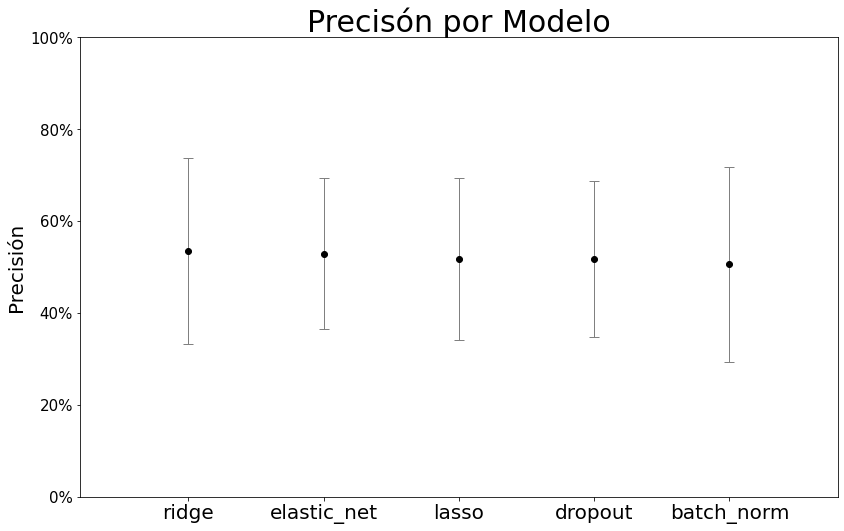

In [ ]:
# get names
names_figures = list(df_acc.index)
x_aux = np.arange(len(names_figures))

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(
    x_aux,
    df_acc['mean'],
    yerr = df_acc['std'],
    capsize=5,
    elinewidth=1,
    color ='black',
    ecolor='gray',
    fmt='o'
)

# add decorators
plt.title("Precisón por Modelo", fontsize=30)

ax.set_ylabel('Precisión', fontsize=20)

ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.ylim(bottom=0, top=1)

plt.xticks(x_aux, names_figures, fontsize=20)
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

# show figure 
plt.show()

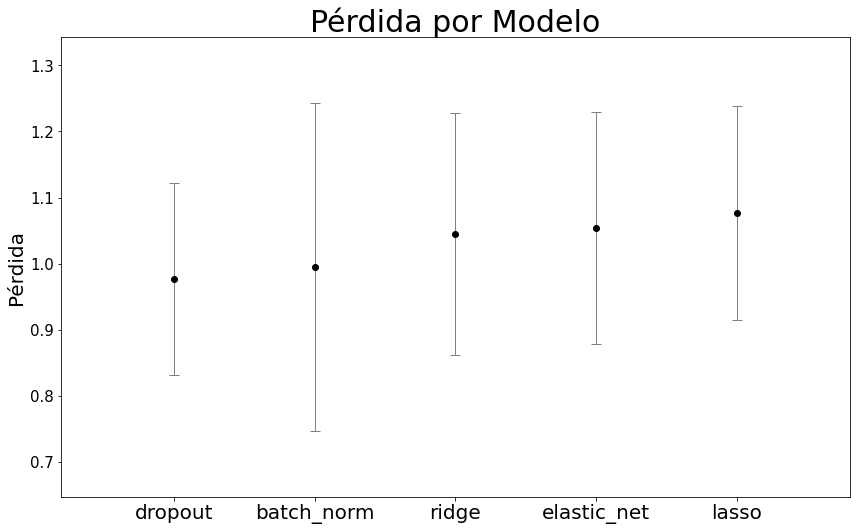

In [ ]:
# get names
names_figures = list(df_loss.index)
x_aux = np.arange(len(names_figures))

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(
    x_aux,
    df_loss['mean'],
    yerr = df_loss['std'],
    capsize=5,
    elinewidth=1,
    color ='black',
    ecolor='gray',
    fmt='o'
)

# add decorators
plt.title("Pérdida por Modelo", fontsize=30)

ax.set_ylabel('Pérdida', fontsize=20)

ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', labelsize=15)


plt.xticks(x_aux, names_figures, fontsize=20)
plt.margins(0.2)
plt.subplots_adjust(bottom=0.15)

# reescale plot
fig.tight_layout(rect=[0, 0.03, 1*2, 0.95*2])

# show figure 
plt.show()